In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
import importlib
import matplotlib as mpl
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

%matplotlib inline

## Problem definition

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
df = df.drop(columns=['fnlwgt', 'education-num'])

In [4]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


In [5]:
y.head()

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): [>50K, <=50K]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

X_train, X_test, y_train, y_test = train_test_split(
    df, y, random_state=42
)

clf = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

In [7]:
print(f"The accuracy of my classifier is "
      f"{clf.score(X_train, y_train):.3f}")

The accuracy of my classifier is 0.759


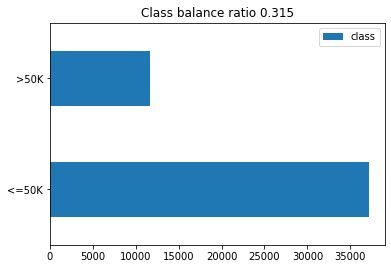

In [8]:
target_counts = y.value_counts()
target_counts.plot(kind='barh', legend=True)
_ = plt.title(f"Class balance ratio "
              f"{target_counts.min() / target_counts.max():.3f}")

### Let's make a baseline

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36631 entries, 27859 to 15795
Data columns (total 12 columns):
age               36631 non-null float64
workclass         34518 non-null category
education         36631 non-null category
marital-status    36631 non-null category
occupation        34509 non-null category
relationship      36631 non-null category
race              36631 non-null category
sex               36631 non-null category
capital-gain      36631 non-null float64
capital-loss      36631 non-null float64
hours-per-week    36631 non-null float64
native-country    36002 non-null category
dtypes: category(8), float64(4)
memory usage: 1.7 MB


In [10]:
num_cols = [col for col in df
            if df[col].dtype.name != 'category']
cat_cols = [col for col in df
            if df[col].dtype.name == 'category']

In [11]:
print(f"The numerical columns are\n {num_cols}")
print(f"The categorical columns are\n {cat_cols}")

The numerical columns are
 ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
The categorical columns are
 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [12]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_preprocessor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknwon',
                  add_indicator=True),
    OneHotEncoder(handle_unknown='ignore')
)
num_preprocessor = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='mean', add_indicator=True)
)

In [13]:
preprocessor = make_column_transformer(
    (cat_preprocessor, cat_cols),
    (num_preprocessor, num_cols)
)

In [14]:
from sklearn.linear_model import LogisticRegression

model = make_pipeline(
    preprocessor, LogisticRegression(max_iter=10000)
)

In [15]:
model.fit(X_train, y_train).score(X_test, y_test)

0.8575874211776268

## The metrics 

### From scikit-learn

In [16]:
def print_metric(metric, clf, X, y_true, metric_params=None):
    assert X.shape[0] == y_true.shape[0], "Different samples size!!!"
    y_pred = clf.predict(X)
    if metric_params is None:
        metric_params = {}
    score = metric(y_true, y_pred, **metric_params)
    print(f"The {metric.__name__.replace('_' , ' ')} "
          f"is {score:.3f}")

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
print_metric(accuracy_score, model, X_test, y_test)

The accuracy score is 0.858


In [19]:
from sklearn.metrics import balanced_accuracy_score

In [20]:
print_metric(balanced_accuracy_score, model, X_test, y_test)

The balanced accuracy score is 0.771


In [21]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[8734,  620],
       [1119, 1738]])

(0, 2)

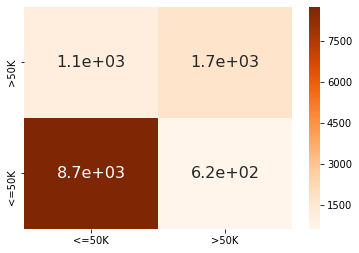

In [22]:
cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=clf.classes_,
    index=clf.classes_
)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, annot=True, annot_kws={"size": 16},
            cmap='Oranges',)

plt.xlim(0, 2)
plt.ylim(0, 2)

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

for metric in (precision_score, recall_score, f1_score):
    print_metric(metric, model, X_test, y_test,
                 {'pos_label': '>50K'})

The precision score is 0.737
The recall score is 0.608
The f1 score is 0.667


In [24]:
for metric in (precision_score, recall_score, f1_score):
    print_metric(metric, model, X_test, y_test,
                 {'pos_label': '<=50K'})

The precision score is 0.886
The recall score is 0.934
The f1 score is 0.909


In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      9354
        >50K       0.74      0.61      0.67      2857

    accuracy                           0.86     12211
   macro avg       0.81      0.77      0.79     12211
weighted avg       0.85      0.86      0.85     12211



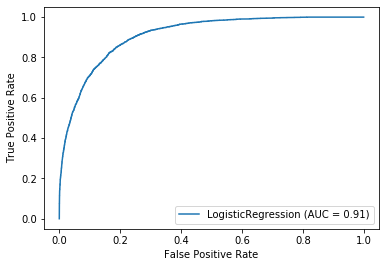

In [26]:
from sklearn.metrics import plot_roc_curve

_ = plot_roc_curve(model[-1], model[0].transform(X_test), y_test)

In [27]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_test)
print(f"The ROC-AUC score is "
      f"{roc_auc_score(y_test, y_pred[:, 1]):.3f}")

The ROC-AUC score is 0.911


### From imbalanced-learn

In [28]:
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score

for metric in (specificity_score, sensitivity_score):
    print_metric(metric, model, X_test, y_test,
                 {'pos_label': '>50K'})

The specificity score is 0.934
The sensitivity score is 0.608


In [29]:
from imblearn.metrics import classification_report_imbalanced

y_pred = model.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

      <=50K       0.89      0.93      0.61      0.91      0.75      0.59      9354
       >50K       0.74      0.61      0.93      0.67      0.75      0.55      2857

avg / total       0.85      0.86      0.68      0.85      0.75      0.58     12211



In [30]:
from imblearn.metrics import geometric_mean_score

print_metric(geometric_mean_score, model, X_test, y_test)

The geometric mean score is 0.754


## The influence of imbalanced dataset on machine-learning model

#### Linear classifier

In [31]:
def plot_decision_function(X, y, clf, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[np.flatnonzero(y == 1), 0],
               X[np.flatnonzero(y == 1), 1],
               color='yellow', alpha=0.8, edgecolor='k')
    ax.scatter(X[np.flatnonzero(y == 0), 0],
               X[np.flatnonzero(y == 0), 1],
              color='indigo', alpha=0.8, edgecolor='k')

In [32]:
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.5, 0.5],
                           class_sep=1.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)
model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
_ = model.fit(X_train, y_train)

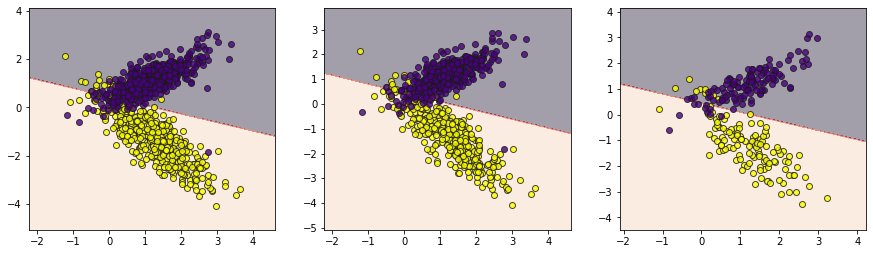

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
plot_decision_function(X, y, model, ax=ax[0])
plot_decision_function(X_train, y_train, model, ax=ax[1])
plot_decision_function(X_test, y_test, model, ax=ax[2])

In [34]:
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.05, 0.95],
                           class_sep=1.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [35]:
_ = model.fit(X_train, y_train)

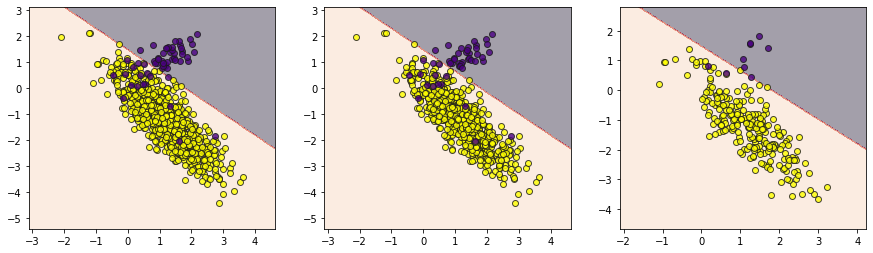

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
plot_decision_function(X, y, model, ax=ax[0])
plot_decision_function(X_train, y_train, model, ax=ax[1])
plot_decision_function(X_test, y_test, model, ax=ax[2])

Let's recall the loss function for the logistic regression in the binary case:

$L(\theta) = - \frac{1}{m} \sum_{i=1}^{m}\left[ y^{(i)} \log \left( h_{\theta} (x^{(i)}) \right) + \left( 1 - y^{(i)} \right) \log \left( 1 - h_{\theta} (x^{(i)}) \right) \right]$

We sum over the sample without applying any weights.

#### Tree-based model

![](hellinger.png)

![](proba.png)

## What can we do about it?

In [37]:
df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
df = df.drop(columns=['fnlwgt', 'education-num'])

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

X_train, X_test, y_train, y_test = train_test_split(
    df, y, random_state=42
)

In [39]:
# Helper function to evaluate the different models
def evaluate_classifier(clf, df_all_scores):
    name = getattr(clf, 'name', clf.__class__.__name__)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    df_score = pd.DataFrame(
        {name: [score, balanced_score]}, 
        index=['Test accuracy', 'Balanced accuracy']
    )
    df_all_scores = pd.concat([df_all_scores, df_score], axis=1).round(decimals=3)
    return df_all_scores

### From scikit-learn

#### Baseline classifier

As we have seen before, we will compare the new classifiers with a dummy baseline which predict the most frequent label in the dataset. This baseline will highlight the improvement compared to naive strategies.

In [40]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.name = "Most Frequent Classifier"

df_all_scores = pd.DataFrame()
df_all_scores = evaluate_classifier(dummy_clf, df_all_scores)
df_all_scores

,Most Frequent Classifier
Test accuracy,0.766
Balanced accuracy,0.500


#### Make use of the `class_weight` parameter

A first class of methods rely on sample weights to correct the imbalance. The core idea here is to weight prediction mistakes on the minority class higher than mistakes on the most common class.

##### In linear model

In `scikit-learn`, some estimators have a `class_weight` parameter that permits to do this. The idea is that the ERM is changed such that
$$
    \arg\min_\theta \frac{1}{\sum_i w_i} \sum_i w_i 1\{f_\theta(X_i) = y_i\}
$$
with weights $w_i = \frac{n}{kn_i}$ with $n$ the total number of samples, $k$ the number of classes and $n_i$ the number of samples from class $y_i$. This effectively rebalance the training in learning both from positive and negative examples.



In [41]:
cat_preprocessor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknwon',
                  add_indicator=True),
    OneHotEncoder(handle_unknown='ignore')
)

num_preprocessor = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='mean', add_indicator=True)
)

In [42]:
preprocessor_lr = make_column_transformer(
    (cat_preprocessor, cat_cols),
    (num_preprocessor, num_cols)
)

In [43]:
from sklearn.linear_model import LogisticRegression

model_lr = make_pipeline(
    preprocessor_lr, LogisticRegression(max_iter=10000)
)
model_lr.name = 'Logistic Regression'

In [44]:
df_all_scores = evaluate_classifier(model_lr, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression
Test accuracy,0.766,0.858
Balanced accuracy,0.500,0.771


We can set the `class_weight='balanced'` uses the values of `y` to automatically adjust weights inversely proportional to class frequencies in the input data.

In [45]:
from sklearn.base import clone

model_lr_balanced = clone(model_lr)
model_lr_balanced.set_params(
    logisticregression__class_weight='balanced')
model_lr_balanced.name = "Logistic Regression with balanced weights"
df_all_scores = evaluate_classifier(model_lr_balanced, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights
Test accuracy,0.766,0.858,0.816
Balanced accuracy,0.500,0.771,0.829


#### In tree-based model

In tree based models, the `class_weight` option is used to chose on the splits. Indeed, the purity criterion (which is minimize for to chose the split) is computed using these weights. In the leaf, the weights are used to compute the class to output.

In [46]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

cat_preprocessor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknwon',
                  add_indicator=True),
    OrdinalEncoder()
)

num_preprocessor = SimpleImputer(strategy='mean', add_indicator=True)

preprocessor_rf = make_column_transformer(
    (cat_preprocessor, cat_cols),
    (num_preprocessor, num_cols)
)
model_rf = make_pipeline(
    preprocessor_rf,
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
model_rf.name = "Random Forest"

In [47]:
df_all_scores = evaluate_classifier(model_rf, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest
Test accuracy,0.766,0.858,0.816,0.858
Balanced accuracy,0.500,0.771,0.829,0.780


In [48]:
model_rf_balanced = clone(model_rf)
model_rf_balanced.set_params(
    randomforestclassifier__class_weight='balanced')
model_rf_balanced.name = "Balanced Random Forest"

df_all_scores = evaluate_classifier(model_rf_balanced, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest
Test accuracy,0.766,0.858,0.816,0.858,0.852
Balanced accuracy,0.500,0.771,0.829,0.780,0.783


For ensemble models, `class_weight` can also take value `balanced_subsample`. This option is equivalent to the `'balanced'` one except that the weigths are computed directly for the bootstrap sample of each tree instead of weights computed globally.

In [49]:
model_rf_subbalanced = clone(model_rf)
model_rf_subbalanced.set_params(
    randomforestclassifier__class_weight='balanced_subsample')
model_rf_subbalanced.name = "Balanced Subsample Random Forest"

df_all_scores = evaluate_classifier(model_rf_subbalanced, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest,Balanced Subsample Random Forest
Test accuracy,0.766,0.858,0.816,0.858,0.852,0.853
Balanced accuracy,0.500,0.771,0.829,0.780,0.783,0.785


### 2.3 Resample the training set to have balanced classes

A second option to learn on unbalanced data is to reweight the classes by sampling a new training set with balanced class. This can be done by either subsampling, oversampling or more complicated scheme demonstrated in this section.

#### From imbalanced-learn

#### Random under-sampling during training

In [50]:
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from imblearn.under_sampling import RandomUnderSampler

In [51]:
model_lr_undersampled = make_pipeline_imblearn(
    preprocessor_lr,
    RandomUnderSampler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
model_lr_undersampled.name = "Logistic Regression from rebalanced undersampled data"

In [52]:
df_all_scores = evaluate_classifier(model_lr_undersampled, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest,Balanced Subsample Random Forest,Logistic Regression from rebalanced undersampled data
Test accuracy,0.766,0.858,0.816,0.858,0.852,0.853,0.817
Balanced accuracy,0.500,0.771,0.829,0.780,0.783,0.785,0.830


#### Random over-sampling during training

In [53]:
from imblearn.over_sampling import RandomOverSampler

In [54]:
model_lr_oversampled = make_pipeline_imblearn(
    preprocessor_lr,
    RandomOverSampler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
model_lr_oversampled.name = "Logistic Regression from rebalanced oversampled data"

In [55]:
df_all_scores = evaluate_classifier(model_lr_oversampled, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest,Balanced Subsample Random Forest,Logistic Regression from rebalanced undersampled data,Logistic Regression from rebalanced oversampled data
Test accuracy,0.766,0.858,0.816,0.858,0.852,0.853,0.817,0.817
Balanced accuracy,0.500,0.771,0.829,0.780,0.783,0.785,0.830,0.830


#### More fancy methods


There exists some more fancy methods to re-balance the dataset. For instance the SMOTE method where extra points are generated by creatinig synthetic points for the minority class. See more info on the [original paper](https://arxiv.org/pdf/1106.1813.pdf) or in this [blog post](http://rikunert.com/SMOTE_explained).

In [56]:
from imblearn.over_sampling import SMOTE

In [57]:
model_lr_smote = make_pipeline_imblearn(
    preprocessor_lr,
    SMOTE(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
model_lr_smote.name = "Logistic Regression from SMOTE sampled data"

In [58]:
df_all_scores = evaluate_classifier(model_lr_smote, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest,Balanced Subsample Random Forest,Logistic Regression from rebalanced undersampled data,Logistic Regression from rebalanced oversampled data,Logistic Regression from SMOTE sampled data
Test accuracy,0.766,0.858,0.816,0.858,0.852,0.853,0.817,0.817,0.818
Balanced accuracy,0.500,0.771,0.829,0.780,0.783,0.785,0.830,0.830,0.831


You can look in [imbalanced-learn documentation](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.over_sampling) for more sampling strategies.

### 2.4 Used balanced algorithms: `BalancedRandomForest` and `BalancedBaggingClassifier` 

Instead of just sampling the training set to rebalance the classes, it is also possible to used _balanced_ classifier to fit the unbalanced dataset. The core idea is to use ensemble techniques with specific boostrap sampling strategies that make sure that each bootstrap sample is balanced.

#### Example of `BalancedRandomForestClassifier`

Here, a random forest is learn on the full dataset. Each tree is constructed using a balanced sub-sampled of the dataset.  
This idea has been proposed by [Chen et al. (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf).

In [59]:
from imblearn.ensemble import BalancedRandomForestClassifier

model_balanced_rf = make_pipeline(
    preprocessor_rf,
    BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
model_balanced_rf.name = "Balanced Random Forest"

In [60]:
df_all_scores = evaluate_classifier(model_balanced_rf, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest,Balanced Subsample Random Forest,Logistic Regression from rebalanced undersampled data,Logistic Regression from rebalanced oversampled data,Logistic Regression from SMOTE sampled data,Balanced Random Forest
Test accuracy,0.766,0.858,0.816,0.858,0.852,0.853,0.817,0.817,0.818,0.820
Balanced accuracy,0.500,0.771,0.829,0.780,0.783,0.785,0.830,0.830,0.831,0.839


#### Example of `BalancedBaggingClassifier`

In ensemble classifiers, bagging methods build several estimators on different randomly selected subset of data. In scikit-learn, this classifier is named `BaggingClassifier`. However, this classifier does not allow to balance each subset of data. Therefore, when training on imbalanced data set, this classifier will favor the majority classes.

In [61]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

In [62]:
model_bagging = make_pipeline(
    preprocessor_rf,
    BaggingClassifier(base_estimator=HistGradientBoostingClassifier(),
                      n_estimators=10, random_state=42, n_jobs=-1)
)
model_bagging.name = "Bagging Model"

In [63]:
df_all_scores = evaluate_classifier(model_bagging, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest,Balanced Subsample Random Forest,Logistic Regression from rebalanced undersampled data,Logistic Regression from rebalanced oversampled data,Logistic Regression from SMOTE sampled data,Balanced Random Forest,Bagging Model
Test accuracy,0.766,0.858,0.816,0.858,0.852,0.853,0.817,0.817,0.818,0.820,0.881
Balanced accuracy,0.500,0.771,0.829,0.780,0.783,0.785,0.830,0.830,0.831,0.839,0.807


`BalancedBaggingClassifier `allows to resample each subset of data before to train each estimator of the ensemble. In short, it combines the output of an `EasyEnsemble` sampler with an ensemble of classifiers (i.e. `BaggingClassifier`). Therefore, `BalancedBaggingClassifier `takes the same parameters than the scikit-learn `BaggingClassifier`. Additionally, there is two additional parameters, sampling_strategy and replacement to control the behaviour of the random under-sampler.

In [64]:
from imblearn.ensemble import BalancedBaggingClassifier
model_balanced_bagging = make_pipeline(
    preprocessor_rf,
    BalancedBaggingClassifier(base_estimator=HistGradientBoostingClassifier(),
                              n_estimators=10, random_state=42, n_jobs=-1)
)
model_balanced_bagging.name = "Balanced Bagging Model"

In [65]:
df_all_scores = evaluate_classifier(model_balanced_bagging, df_all_scores)
df_all_scores

,Most Frequent Classifier,Logistic Regression,Logistic Regression with balanced weights,Random Forest,Balanced Random Forest,Balanced Subsample Random Forest,Logistic Regression from rebalanced undersampled data,Logistic Regression from rebalanced oversampled data,Logistic Regression from SMOTE sampled data,Balanced Random Forest,Bagging Model,Balanced Bagging Model
Test accuracy,0.766,0.858,0.816,0.858,0.852,0.853,0.817,0.817,0.818,0.820,0.881,0.836
Balanced accuracy,0.500,0.771,0.829,0.780,0.783,0.785,0.830,0.830,0.831,0.839,0.807,0.847


In [66]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

model = make_pipeline(
    preprocessor, OneClassSVM(kernel='linear', nu=0.1)
)
mask_single_class = y_train == '>50K'
_ = model.fit(X_train[mask_single_class], y_train[mask_single_class])

In [67]:
y_pred = model.predict(X_test)

In [68]:
y_test_converted = (2 * (y_test == '>50K').astype(int)) - 1
score = balanced_accuracy_score(y_test_converted, y_pred)
print(f"Balanced accuracy {score:.2f}")

Balanced accuracy 0.65
